In [14]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from BuoyData import BuoyDataCopernicus, TargetedTimeRange
from data_preprocessing import plot_buoy_data

import random
import datetime
import numpy as np
import folium
import pandas as pd
import xarray as xr
from folium import plugins
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import lux
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
yaml_path = "/home/jonas/Documents/Thesis/OceanPlatformControl/scenarios/generative_error_model/config_buoy_data.yaml"
buoy_data = BuoyDataCopernicus(yaml_path)

...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt


In [7]:
# Vis location of bbox
targeted_bbox = buoy_data.targeted_bbox
x_loc = (targeted_bbox[0]+ targeted_bbox[2])/2
y_loc = (targeted_bbox[1]+ targeted_bbox[3])/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=4).add_to(f)
points = [(targeted_bbox[1], targeted_bbox[0]), (targeted_bbox[3], targeted_bbox[2])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

In [11]:
# save pd for faster testing
path = os.path.join(buoy_data.data_config["data_dir"], "drifter_data", "buoy_data.csv")
buoy_data.data.to_csv(path, index=False)

In [20]:
# read in csv
path = os.path.join(buoy_data.data_config["data_dir"], "drifter_data", "buoy_data.csv")
df = pd.read_csv(path)
print(min(df["lon"]), max(df["lon"]))
print(min(df["lat"]), max(df["lat"]))
print(min(df["time"]), max(df["time"]))

-129.966 -120.002
25.156 30.0
2021-01-01 00:00:00 2021-01-31 23:00:00


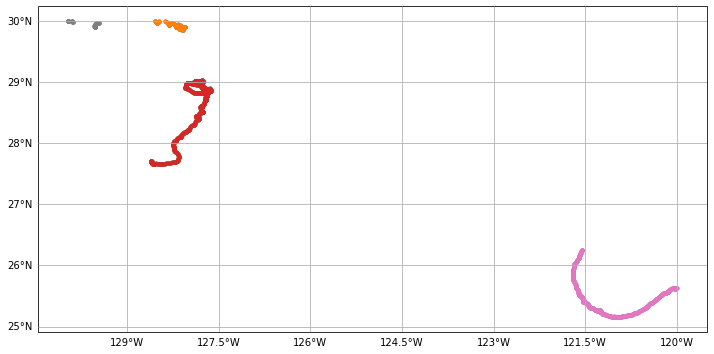

In [15]:
plot_buoy_data(df)

### Get hincasts from opendap

In [14]:
from ocean_navigation_simulator.environment.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.utils import units

# Create the source dict for the ocean currents
source_dict = {'field': 'OceanCurrents'}
source_dict['source'] = 'opendap'
source_dict['source_settings'] = {
                   'service': 'copernicus',
                   'currents': 'total', # if we want to take the normal uo, vo currents or 'total' for tide, normal added
                   'USERNAME': 'jdieker', 'PASSWORD': 'AxxzVqCuC#!vS69',
                   # 'DATASET_ID': 'global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh',
                   'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}

# What is this needed for?
sim_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}

In [18]:
# Create the ocean Field
ocean_field = OceanCurrentField(hindcast_source_dict=source_dict, sim_cache_dict=sim_cache_dict)

t_0 = config["targeted_time_range"][0]
t_interval = [t_0, t_0 + datetime.timedelta(days=7)]
x_interval=[config["targeted_bbox"][2], config["targeted_bbox"][0]]
y_interval=[config["targeted_bbox"][1], config["targeted_bbox"][3]]

Forecast is the same as Hindcast for OceanCurrents.


In [18]:
# get data
ds_hind = ocean_field.hindcast_data_source.get_data_over_area(x_interval, y_interval, t_interval)

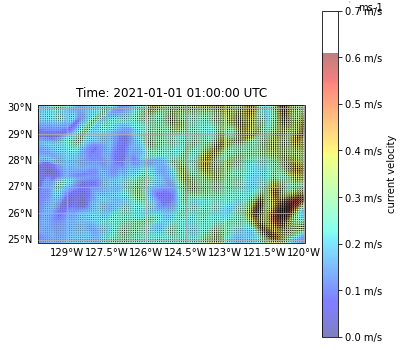

In [7]:
# plot retrieved data
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    plot_type='quiver', return_ax=False)

### Casadi based Interpolation

In [20]:
from ocean_navigation_simulator.environment.PlatformState import PlatformState
from ocean_navigation_simulator.utils import units
platform_state = PlatformState(lon=units.Distance(deg=np.mean(x_interval)), lat=units.Distance(deg=np.mean(y_interval)), date_time=t_0)
ocean_field.hindcast_data_source.update_casadi_dynamics(state=platform_state)

# convert buoy time axis to posix
df["time"] = pd.to_datetime(df["time"])
posix_timestamp = units.get_posix_time_from_np64(df["time"].values)
df["time_posix"] = posix_timestamp

In [21]:
spatio_temporal_points = np.array([df["time_posix"], df["lat"], df["lon"]]).T

import casadi as ca

for i in range(spatio_temporal_points[:10].shape[0]):
    print(f"spatio-temporal point: {spatio_temporal_points[i]}")
    interp_point_u = ocean_field.hindcast_data_source.u_curr_func(spatio_temporal_points[i])
    print(f"interpolated value: {interp_point_u}")

spatio-temporal point: [ 1.60945920e+09  2.62600002e+01 -1.21546997e+02]
interpolated value: 0.0654447
spatio-temporal point: [ 1.60946280e+09  2.62530003e+01 -1.21552002e+02]
interpolated value: 0.054785
spatio-temporal point: [ 1.60946640e+09  2.62460003e+01 -1.21556000e+02]
interpolated value: -0.152411
spatio-temporal point: [ 1.60947000e+09  2.62399998e+01 -1.21557999e+02]
interpolated value: -0.361183
spatio-temporal point: [ 1.60947360e+09  2.62329998e+01 -1.21560997e+02]
interpolated value: -0.678673
spatio-temporal point: [ 1.60947720e+09  2.62280006e+01 -1.21565002e+02]
interpolated value: -1.02057
spatio-temporal point: [ 1.60948080e+09  2.62220001e+01 -1.21568001e+02]
interpolated value: -1.02365
spatio-temporal point: [ 1.60948440e+09  2.62159996e+01 -1.21570000e+02]
interpolated value: -1.01883
spatio-temporal point: [ 1.60948800e+09  2.62119999e+01 -1.21571999e+02]
interpolated value: -1.04847
spatio-temporal point: [ 1.60949160e+09  2.62089996e+01 -1.21573997e+02]
inter

### Multi-dimensional interpolation

In [12]:
def interp_hindcast_xarray(df, n=10):
    from tqdm import tqdm
    df["u_hind"] = 0
    df["v_hind"] = 0
    # convert time column to datetime
    df["time"] = pd.to_datetime(df["time"])

    for i in tqdm(range(0, df.shape[0], n)):
        # hindcast_interp = ds_hind.interp(time=df.iloc[i:i+n]["time"],
        #                                 lon=df.iloc[i:i+n]["lon"],
        #                                 lat=df.iloc[i:i+n]["lat"])
        hindcast_interp = ocean_field.hindcast_data_source.DataArray.interp(time=df.iloc[i:i+n]["time"],
                                                                            lon=df.iloc[i:i+n]["lon"],
                                                                            lat=df.iloc[i:i+n]["lat"])
        # add columns to dataframe
        df["u_hind"][i:i+n] = hindcast_interp["water_u"].values.diagonal().diagonal()
        df["v_hind"][i:i+n] = hindcast_interp["water_v"].values.diagonal().diagonal()
    return df

df = interp_hindcast(df)
# compute error columns
df["u_error"] = df["u_hind"] - df["u"]
df["v_error"] = df["v_hind"] - df["v"]

# # writing df to file
# df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [1]:
# test func
from data_preprocessing import interp_hindcast_xarray

interp_hindcast_xarray(df, ocean_field)
# ocean_field

In [106]:
df_nan = df[df["u_hind"].isna() == True]
df_nan.shape
# df_nan = interp_hindcast(df_nan, n=20)
# print(df_nan.isna().sum())
# df.shape

(117, 10)

In [33]:
# frames = [df, df_nan]
# df = pd.concat(frames)
# print(f"num of rows with nan values: {df.isna().sum()}")

### Scipy based Interpolation

In [10]:
# from ocean_navigation_simulator.env.utils.units import get_posix_time_from_np64
# from scipy.interpolate import RegularGridInterpolator
# from tqdm import tqdm

# # need to convert time to posix time
# # ds = ocean_field.hindcast_data_source.DataArray
# ds = ds_hind
# posix_timestamp = [get_posix_time_from_np64(time) for time in ds["time"].values]
# ds = ds.assign_coords(time_posix=posix_timestamp)

# # define interpolation function (using hindcast coordinates and u,v)
# interp_u = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_u"].values)
# # interp_v = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_v"].values)

# # convert buoy time axis to posix
# df["time"] = pd.to_datetime(df["time"])
# posix_timestamp = [get_posix_time_from_np64(time) for time in df["time"].values]
# df["time_posix"] = posix_timestamp
# df["time_posix"]

# # Define points to interpolate
# points = np.array([df["time_posix"], df["lat"], df["lon"]]).T
# df["u_hind"] = 0
# df["v_hind"] = 0

# # split points into chunks
# n = 2
# for i in tqdm(range(100, points.shape[0], n)):
#     print(points[i:i+n].shape)
#     u_points = interp_u(points[i:i+n])
#     # v_points = interp_v(points[i:i+n])
#     print(u_points)
    
#     # add columns to dataframe
#     df["u_hind"][i:i+n] = u_points
#     # df["v_hind"][i:i+n] = v_points
#     break



In [71]:
from scipy.interpolate import RegularGridInterpolator
def f(x,y,z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))

In [72]:
my_interpolating_function = RegularGridInterpolator((x, y, z), data)
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
print(pts.shape)
my_interpolating_function(pts)

(2, 3)


array([125.80469388, 146.30069388])

### Save Interpolated Data

In [39]:
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [11]:
# load previous csv
df = pd.read_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"))
print(f"count NaN rows: {df['u_hind'].isna().sum()}")

count NaN rows: 117


### Plot Mean and RMSE

In [15]:
from metrics import calc_speed_mean, calc_speed_RMSE

df["RMSE_speed"] = calc_speed_RMSE(df["u_hind"], df["v_hind"], df["u"], df["v"])
df["mean_speed"] = calc_speed_mean(df["u_hind"], df["v_hind"], df["u"], df["v"])

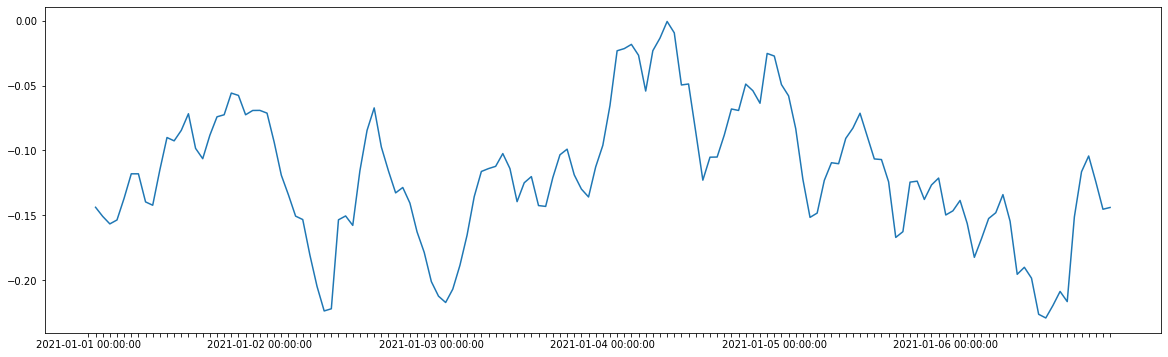

In [27]:
from metrics import plot_metric
df_filt_group = df_filt.groupby(by=["time"], as_index=False).mean()
plot_metric(df_filt_group["time"], df_filt_group["mean_speed"])

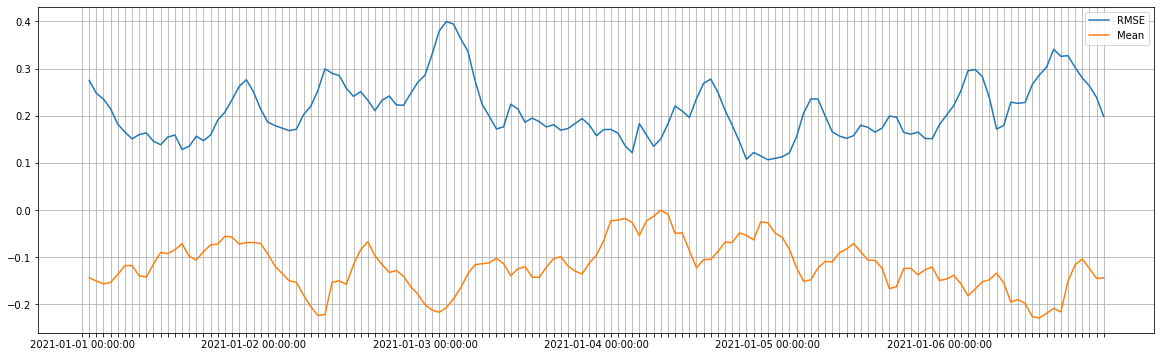

In [26]:
# mean current error vs time
df_filt = df[df["time"] < "2021-01-07"]
df_filt_group = df_filt.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_filt_group["time"], df_filt_group["RMSE_speed"], label="RMSE")
plt.plot(df_filt_group["time"], df_filt_group["mean_speed"], label="Mean")
plt.legend()
plt.grid()

# needed to supress most labels
every_nth = 24
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

In [19]:
def calc_vector_correlation(u_data_hindcast, v_data_hindcast, u_data_measured, v_data_measured, print_out=False):
    """
    Calculates the vector correlation for one buoy for a specific day,
    where one day typically has 24 measurements.
    """

    # Flatten out the vectors
    # first Stack them
    hindcast = np.stack((u_data_hindcast, v_data_hindcast))
    measured = np.stack((u_data_measured, v_data_measured))
    hindcast_vec = hindcast.reshape(2, -1)
    measured_vec = measured.reshape(2, -1)
    # Step 1: calculate the correlation matrix
    full_variable_vec = np.vstack((measured_vec, hindcast_vec))
    Covariance_matrix = np.cov(full_variable_vec)
    # calculation for vector correlation
    Sigma_11 = Covariance_matrix[:2,:2]
    Sigma_22 = Covariance_matrix[2:,2:]
    Sigma_12 = Covariance_matrix[:2,2:]
    Sigma_21 = Covariance_matrix[2:,:2]
    # Matrix multiplications
    epsilon = 0
    vector_correlation = np.trace(np.linalg.inv(Sigma_11) @ Sigma_12 @ np.linalg.inv(Sigma_22) @ Sigma_21)
    while np.isnan(vector_correlation):
        epsilon += 5e-5
        vector_correlation = np.trace(np.linalg.inv(Sigma_11 + epsilon*np.eye(2)) @ Sigma_12 @ np.linalg.inv(Sigma_22 + epsilon*np.eye(2)) @ Sigma_21)
        if epsilon > 1e-1:
            break
    return vector_correlation

def get_vector_correlation_per_day(df_day):
    """
    Calculates the vector correlation per day per buoy and takes the average for that day

    Expects a dataframe with data from one or more buoys over one day
    """
    buoy_names = set(df_day["buoy"].tolist())
    vec_corr_total = 0
    for name in buoy_names:
        points_buoy = df_day[df_day["buoy"] == name]
        vec_corr = calc_vector_correlation(points_buoy["u_hind"],
                                                points_buoy["v_hind"],
                                                points_buoy["u"],
                                                points_buoy["v"])
        if np.isnan(vec_corr):
            vec_corr = 0
        vec_corr_total += vec_corr
    if len(buoy_names) != 0:
        return vec_corr_total/len(buoy_names)
    return -1

def get_vector_correlation_over_time(df):
    """
    Gets the vector correlation over the entire time range covered in the dataframe
    """
    df["day"] = df["time"].apply(lambda x: x[:10])
    days = sorted(set(df["day"].tolist()))
    vec_corr = []
    for day in days:
        df_day = df[df["day"] == day]
        vec_corr.append(get_vector_correlation_per_day(df_day))
    df_vec_corr = pd.DataFrame({"day": days, "vec_corr": vec_corr})
    return df_vec_corr


df["day"] = df["time"].apply(lambda x: x[:10])
df_vec_corr = get_vector_correlation_over_time(df[df["day"] == df["day"].tolist()[0]])

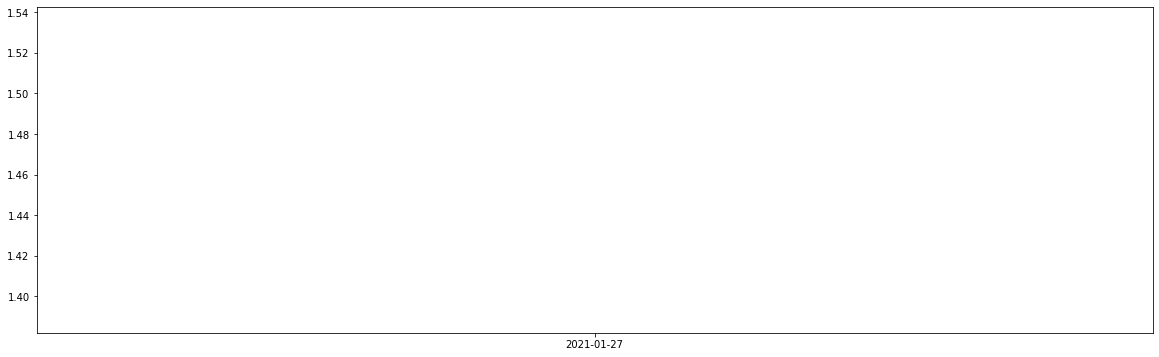

In [20]:
# plotting vector correlation (where the plot is zero no or only one buoy provided a measurement)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df_vec_corr["day"], df_vec_corr["vec_corr"], label="Vector Correlation")

# needed to supress most labels
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Plot Spatial Error

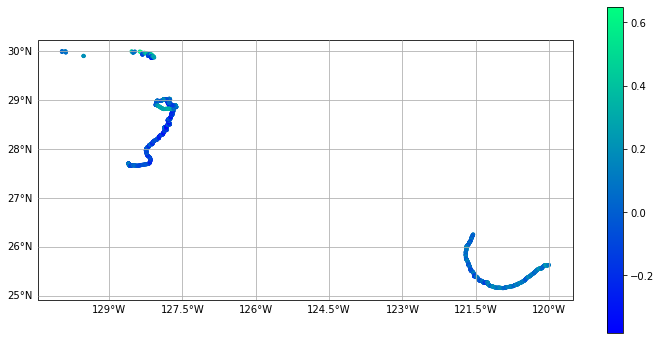

In [105]:
# spatial plot of error
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

plt.scatter(df["lon"], df["lat"], c=df["u_error"], marker=".", cmap="winter")
plt.colorbar()
plt.show()

Plot above is for an area of 500 km by 984 km